# 88Sr⁺ Energy Level Visualization Demo

In this notebook, we:
- Load Sr⁺ ion energy-level data from JSON files.
- Apply **Zeeman splitting** and **motional sidebands** automatically.
- Configure layout and style for clear diagrams.
- Plot experimental configurations: optical pumping, detection, Doppler and sideband cooling.

Goal: demonstrate both the **code pipeline** and the **physics context** behind the figures.


In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Iterable, List

from energy_level_generator.models import Level
from energy_level_generator.splitters import ZeemanSplitter, SidebandSplitter
from energy_level_generator.layout import LayoutConfig
from energy_level_generator.style import StyleConfig
from energy_level_generator.plotter import plot_energy_levels


## Helper Functions

In [2]:
def _sanitize(obj: Any) -> Any:
    """Return a JSON-safe version (Levels→label)."""
    if isinstance(obj, Level):
        return obj.label
    if isinstance(obj, dict):
        return {k: _sanitize(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [_sanitize(v) for v in obj]
    try:
        json.dumps(obj); return obj
    except TypeError:
        return repr(obj)

def _level_to_shallow_dict(lvl: Level) -> dict:
    """Flatten Level for debug printing."""
    return {
        "label": lvl.label,
        "energy": lvl.energy,
        "zeeman": lvl.zeeman,
        "sideband": _sanitize(lvl.sideband),
        "sublevel": lvl.sublevel,
        "parent": lvl.parent.label if isinstance(lvl.parent, Level) else lvl.parent,
        "split_type": lvl.split_type,
        "children": [c.label if isinstance(c, Level) else c for c in (lvl.children or [])],
        "meta": _sanitize(lvl.meta),
    }

def dump_levels(levels: Iterable[Level], sort: bool=True, n:int=10) -> None:
    """Quick peek at first `n` flattened levels (sorted by energy, label)."""
    items = list(levels)
    if sort:
        items.sort(key=lambda l: (getattr(l, "energy", 0.0), getattr(l, "label", "")))
    for row in [_level_to_shallow_dict(x) for x in items[:n]]:
        print(row)


## Physical Background

88Sr⁺ has low-lying levels: 
- **5s² S₁/₂** (ground state), 
- **5p² P₁/₂, 5p² P₃/₂** (excited), 
- **4d² D₃/₂, D₅/₂** (metastable).  

In a magnetic field (**Zeeman effect**), each level with total angular momentum *J* splits into **m<sub>j</sub> sublevels**:  
energy shift ∝ g<sub>J</sub> μ<sub>B</sub> B m<sub>j</sub>.

**Motional sidebands**: Additional levels spaced by trap frequency appear around certain states when ions are trapped; used in resolved-sideband cooling.

We'll use these concepts to automatically add substructure to base levels before plotting.


## Parameters

- `b_tesla`: Zeeman field (Tesla).
- `sideband_gap`: sideband offset (same units as energies).
- `attach_sidebands_to_zeeman`: attach sidebands to matched Zeeman child m_j (True) or base (False).


In [3]:
DATA_DIR = Path("energy_level_generator/data")

b_tesla = 0.01
sideband_gap = 10.0
attach_sidebands_to_zeeman = True

# Files to render
SCENES = {
    "Prep |↓⟩":      DATA_DIR / "SrPrepDown.json",
    "Prep |↑⟩":      DATA_DIR / "SrPrepUp.json",
    "Detect":        DATA_DIR / "SrDetect.json",
    "Doppler Cooling": DATA_DIR / "SrDopplerCooling.json",
    "Sideband Cooling": DATA_DIR / "SrSidebandCooling.json",
}


## Load JSON → Levels, optionally apply splitters


In [4]:
def load_and_split(path: Path, *, b_tesla: float, sideband_gap: float, attach_to_zeeman: bool) -> dict:
    """Return a `data` dict ready for `plot_energy_levels`."""
    raw = json.loads(path.read_text(encoding="utf-8"))
    levels = [Level(**entry) for entry in raw["levels"]]
    data = {
        "ion": raw.get("ion", ""),
        "unit": raw.get("unit", "cm⁻¹"),
        "levels": levels,
        "transitions": raw.get("transitions", []),
        "title": raw.get("title", ""),
    }

    zs = ZeemanSplitter(b_tesla=b_tesla)
    sb = SidebandSplitter(gap=sideband_gap)

    base_levels = list(data["levels"])
    split_levels: List[Level] = []
    for lvl in base_levels:
        split_levels.append(lvl)
        zkids = zs.split(lvl) if b_tesla > 0 else []
        split_levels.extend(zkids)
        if sideband_gap > 0:
            split_levels.extend(sb.split(lvl, zeeman_children=zkids) if attach_to_zeeman else sb.split(lvl))
    data["levels"] = split_levels
    return data


## Layout and style

- Columns keyed by term letters+J (e.g., S1/2, P1/2, P3/2, …).
- Uniform sublevel spacing for clean visual separation.


In [5]:
def default_layout() -> LayoutConfig:
    return LayoutConfig(
        column_letters=["S1/2", "P1/2", "P3/2", "D3/2", "D5/2"],
        column_positions=[0, 0, 1, 2, 2],
        spacing=1.0,
        bar_half=0.30,
        x_jitter=0.25,
        y_jitter=100.0,
        energy_group_key=lambda lvl: int(lvl.energy // 10000),
        energy_group_y_scale=30.0,
        sublevel_uniform_spacing=1000.0,
        sublevel_uniform_centered=True,
    )

def default_style() -> StyleConfig:
    s = StyleConfig()
    s.hide_split_types = {"sideband"}  # Hides sideband labels
    s.show_qnum_header = True
    s.qnum_header_pad_factor = 0.70
    s.zeeman_label_value_only = True
    s.qnum_header_x_shift = 0.02
    s.qnum_value_x_shift = 0.00
    s.sublevel_value_fontfamily = "DejaVu Sans Mono"
    # s.hide_split_types = {"sideband"}  # uncomment to hide sideband ticks/labels
    return s


## Sanity Check: Inspect Levels

Before plotting, it's important to **inspect and validate** the level data:
- Ensures each level has a valid label, energy, and correct parent-child hierarchy.
- Prevents plot errors (e.g., missing `split_type`, mis-labeled m<sub>j</sub>).
- Confirms that Zeeman and sideband splitters created the expected sublevels.

Below, we print a few parsed levels to confirm the structure.


In [6]:
data = load_and_split(SCENES["Sideband Cooling"], b_tesla=b_tesla, sideband_gap=sideband_gap, attach_to_zeeman=attach_sidebands_to_zeeman)
dump_levels(data["levels"], n=5)


{'label': '5s  2S1/2, m_j=-1/2', 'energy': -0.004668644771929822, 'zeeman': False, 'sideband': None, 'sublevel': 1, 'parent': '5s  2S1/2', 'split_type': 'zeeman', 'children': [], 'meta': {}}
{'label': '5s  2S1/2', 'energy': 0.0, 'zeeman': True, 'sideband': None, 'sublevel': 0, 'parent': None, 'split_type': None, 'children': ['5s  2S1/2, m_j=-1/2', '5s  2S1/2, m_j=+1/2'], 'meta': {}}
{'label': '5s  2S1/2, m_j=+1/2', 'energy': 0.004668644771929822, 'zeeman': False, 'sideband': None, 'sublevel': 1, 'parent': '5s  2S1/2', 'split_type': 'zeeman', 'children': [], 'meta': {}}
{'label': '4d  2D3/2, m_j=-3/2', 'energy': 14646.994397626273, 'zeeman': False, 'sideband': None, 'sublevel': 1, 'parent': '4d  2D3/2', 'split_type': 'zeeman', 'children': [], 'meta': {}}
{'label': '4d  2D3/2, m_j=-1/2', 'energy': 14646.99813254209, 'zeeman': False, 'sideband': None, 'sublevel': 1, 'parent': '4d  2D3/2', 'split_type': 'zeeman', 'children': [], 'meta': {}}


## Render all target figures


### Prep |↓⟩

Preparation of the ion into **|↓⟩** using σ⁻ at 422 nm. Spontaneous decay and 1092 nm repump shown.

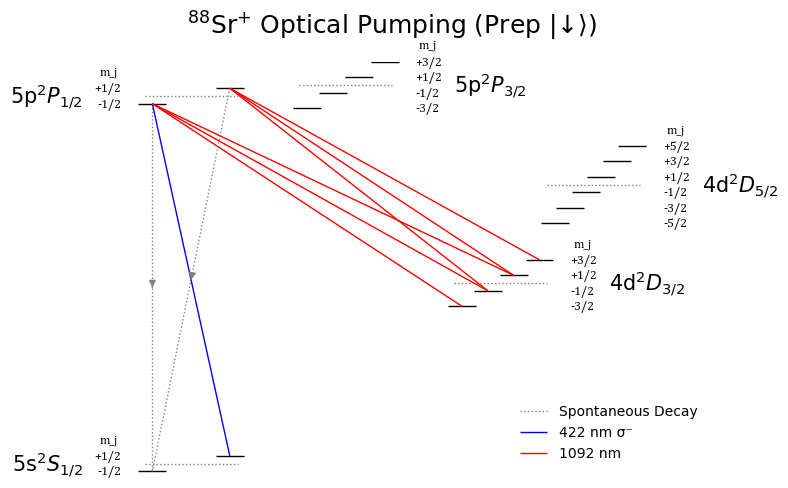

### Prep |↑⟩

Preparation of **|↑⟩** with opposite polarization (σ⁺). Repumping prevents shelving in D-states.

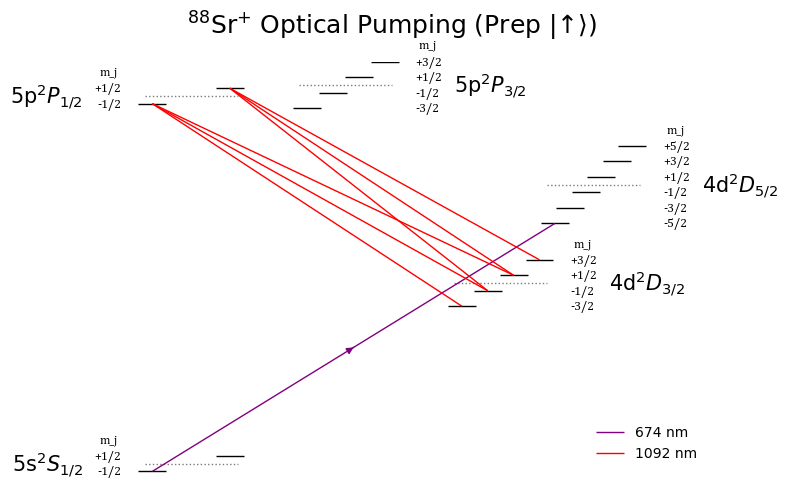

### Detect

State detection on the 422 nm cycling transition; bright/dark discrimination depends on photon scattering.

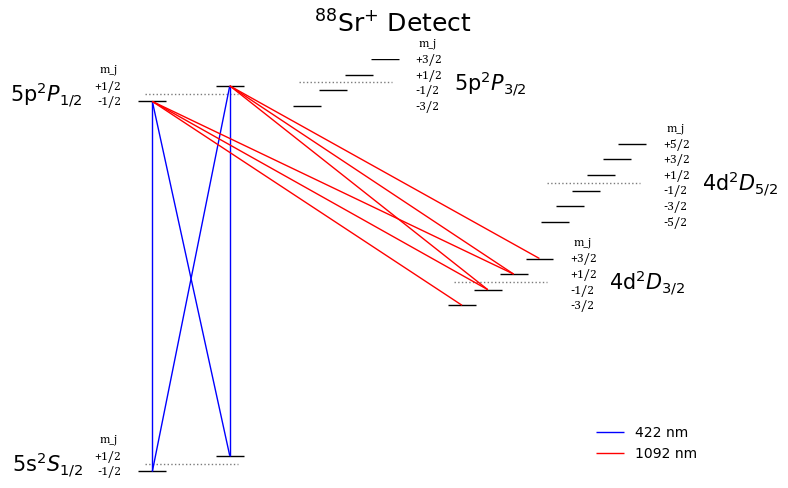

### Doppler Cooling

Red-detuned 422 nm for Doppler cooling; 1092 nm repump clears D-state population.

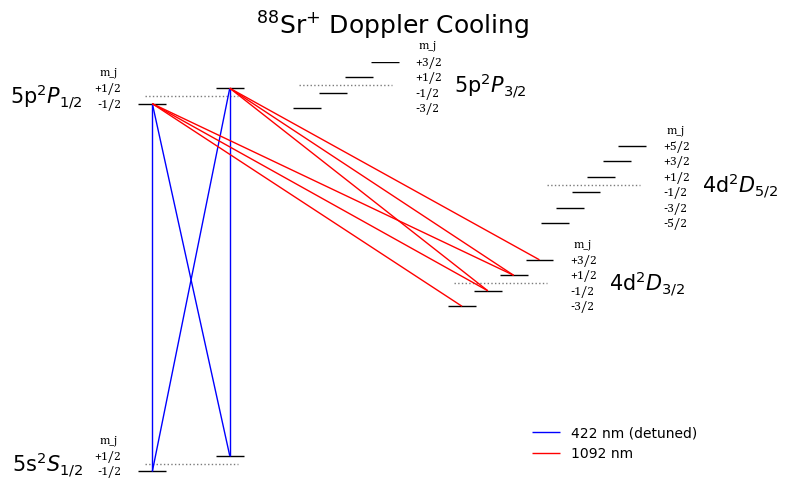

### Sideband Cooling

Resolved sideband cooling using 674 nm; drive/red-sideband transitions to remove motion.

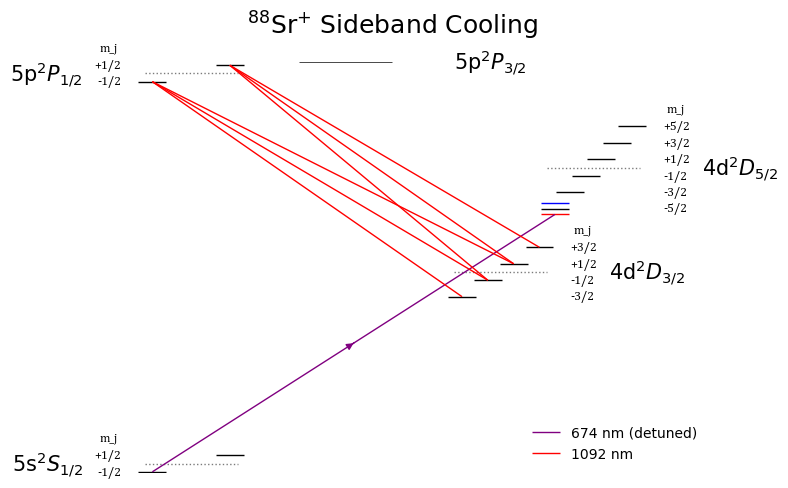

In [7]:
from IPython.display import display, Markdown

EXPLAINS = {
    "Prep |↓⟩": (
        "Preparation of the ion into **|↓⟩** using σ⁻ at 422 nm. "
        "Spontaneous decay and 1092 nm repump shown."
    ),
    "Prep |↑⟩": (
        "Preparation of **|↑⟩** with opposite polarization (σ⁺). "
        "Repumping prevents shelving in D-states."
    ),
    "Detect": (
        "State detection on the 422 nm cycling transition; bright/dark "
        "discrimination depends on photon scattering."
    ),
    "Doppler Cooling": (
        "Red-detuned 422 nm for Doppler cooling; 1092 nm repump clears D-state population."
    ),
    "Sideband Cooling": (
        "Resolved sideband cooling using 674 nm; drive/red-sideband transitions to remove motion."
    ),
}

for title, path in SCENES.items():
    # show the explanation markdown first
    display(Markdown(f"### {title}\n\n{EXPLAINS.get(title, '')}"))

    data = load_and_split(
        path,
        b_tesla=b_tesla,
        sideband_gap=sideband_gap,
        attach_to_zeeman=attach_sidebands_to_zeeman,
    )
    data["title"] = data.get("title") or title
    plot_energy_levels(data, default_layout(), default_style(), show_axis=False)



## Optional: save each figure to disk


In [8]:
# import matplotlib.pyplot as plt

# OUT_DIR = Path("figures"); OUT_DIR.mkdir(exist_ok=True)
# for title, path in SCENES.items():
#     data = load_and_split(path, b_tesla=b_tesla, sideband_gap=sideband_gap, attach_to_zeeman=attach_sidebands_to_zeeman)
#     data["title"] = data.get("title") or title
#     plot_energy_levels(data, default_layout(), default_style(), show_axis=False)
#     safe = title.replace(" ", "_").replace("|", "").replace("↑","up").replace("↓","down")
#     plt.gcf().savefig(OUT_DIR / f"{safe}.png", dpi=300, bbox_inches="tight")
#     plt.close()
# print("Saved to", OUT_DIR.resolve())


## Summary
We built plots directly from structured JSON data:
- Automated Zeeman and sideband splitting.
- Configurable layout and style.
- Physics meaning preserved in labels and transitions.

This workflow makes it easy to generate consistent, physics-aware level diagrams for multiple experimental configurations.
